In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Problem Statement

Home loan default prediction is a critical problem in the banking domain.
Financial institutions face significant risk when lending to customers who
may default on loan repayment.

The objective of this project is to analyze historical loan application data
and build a predictive model that can identify whether a customer is likely
to default on a home loan.


## Business Objective

The primary business objective of this project is to minimize financial loss
by identifying high-risk customers before loan approval.

Specifically, this project aims to:
- Predict whether a customer will default on a home loan.
- Identify key factors influencing loan default.
- Segment customers into different risk categories.
- Recommend the best predictive model suitable for production deployment.


## Dataset Description

The dataset used in this project is provided by Home Credit and contains
historical loan application data.

- Each row represents a unique loan application.
- The target variable indicates whether the applicant defaulted on the loan.
- The dataset contains demographic, financial, and credit-related features.

Target Variable:
- 1 → Defaulter
- 0 → Non-Defaulter


## Project Approach

The project follows a structured data science workflow:

1. Data Understanding and Quality Assessment
2. Data Cleaning and Preprocessing
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Model Building using multiple algorithms
6. Model Evaluation and Comparison
7. Customer Risk Segmentation
8. Final Model Selection and Conclusion

This approach ensures both predictive performance and business interpretability,
which are essential for banking applications.


In [2]:
#loading all the files 
app_train = pd.read_csv('application_train.csv')
SK_ID_CURR = 'SK_ID_CURR'
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
previous_application = pd.read_csv('previous_application.csv')
installments_payments = pd.read_csv('installments_payments.csv')
pos_cash = pd.read_csv('POS_CASH_balance.csv')
credit_card = pd.read_csv('credit_card_balance.csv')

In [3]:
#checking no of rows and column before merging
app_train.shape

(307511, 122)

In [4]:
# -------------------------------------------------------------
# Aggregating Bureau Balance data to capture credit history span
# -------------------------------------------------------------

loan_monthly_summary = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min', 'max', 'size'],
    'STATUS': ['count']
})

# flatten multi-level column names
loan_monthly_summary.columns = ['_'.join(col).strip() for col in loan_monthly_summary.columns]
loan_monthly_summary = loan_monthly_summary.reset_index()

# -------------------------------------------------------------
# Merging aggregated bureau balance with bureau data
# -------------------------------------------------------------

full_history_book = bureau.merge(
    loan_monthly_summary,
    on='SK_ID_BUREAU',
    how='left'
)

# -------------------------------------------------------------
# Aggregating bureau data at customer level (SK_ID_CURR)
# -------------------------------------------------------------

customer_history_summary = full_history_book.groupby(SK_ID_CURR).agg({
    'DAYS_CREDIT': ['min', 'max', 'mean', 'sum'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'MONTHS_BALANCE_size': ['mean', 'sum']
})

# rename columns for clarity and traceability
customer_history_summary.columns = [
    'BUREAU_' + col[0] + '_' + col[1].upper()
    for col in customer_history_summary.columns
]

# -------------------------------------------------------------
# Merging bureau aggregated features with main application data
# -------------------------------------------------------------

app_train = app_train.merge(
    customer_history_summary,
    on=SK_ID_CURR,
    how='left'
)

### Bureau and Bureau Balance Data Aggregation

Bureau and bureau balance datasets contain multiple historical credit records
for each customer. To avoid duplication and ensure a single record per customer,
these datasets were aggregated using statistical measures such as minimum,
maximum, mean, and sum.

The aggregated bureau-level features were then merged with the main application
dataset using the customer identifier (`SK_ID_CURR`).


In [5]:
# -------------------------------------------------------------
# Transforming categorical variables in previous applications
# -------------------------------------------------------------

previous_applications_transformed = pd.get_dummies(
    previous_application,
    columns=['NAME_CONTRACT_STATUS', 'NAME_CASH_LOAN_PURPOSE']
)

# -------------------------------------------------------------
# Aggregating previous application data at customer level
# -------------------------------------------------------------

prev_features = previous_applications_transformed.groupby(SK_ID_CURR).agg({
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'NAME_CONTRACT_STATUS_Refused': ['sum', 'mean'],
    'NAME_CONTRACT_STATUS_Approved': ['sum'],
    'DAYS_DECISION': ['max', 'mean'],
    'SK_ID_PREV': ['count']
})

# renaming columns for better readability
prev_features.columns = [
    'PREV_' + col[0] + '_' + col[1].upper()
    for col in prev_features.columns
]

# -------------------------------------------------------------
# Merging previous application features with main dataset
# -------------------------------------------------------------

app_train = app_train.merge(
    prev_features,
    on=SK_ID_CURR,
    how='left'
)

### Previous Application Data Aggregation

Previous application data contains historical loan application details
for each customer. Categorical variables were converted into numerical
format using one-hot encoding, and the data was aggregated at the customer
level using statistical measures.

These aggregated features help capture the customer’s past loan behavior
and decision history before merging with the main application dataset.


In [6]:
# -------------------------------------------------------------
# Creating payment delay (DPD) and missed payment indicators
# -------------------------------------------------------------

installments_payments['DPD'] = (
    installments_payments['DAYS_ENTRY_PAYMENT']
    - installments_payments['DAYS_INSTALMENT']
)

installments_payments['MISSED_PAYMENT'] = installments_payments['DPD'].apply(
    lambda x: 1 if x > 0 else 0
)

# -------------------------------------------------------------
# Aggregating installment payment behavior at customer level
# -------------------------------------------------------------

ins_features = installments_payments.groupby(SK_ID_CURR).agg({
    'DPD': ['max', 'mean', 'sum'],
    'MISSED_PAYMENT': ['sum', 'mean'],
    'AMT_INSTALMENT': ['max', 'sum']
})

# renaming columns for clarity
ins_features.columns = [
    'INS_' + col[0] + '_' + col[1].upper()
    for col in ins_features.columns
]

# -------------------------------------------------------------
# Merging installment payment features with main dataset
# -------------------------------------------------------------

app_train = app_train.merge(
    ins_features,
    on=SK_ID_CURR,
    how='left'
)


### Installment Payment Behavior Aggregation

Installment payment data provides insights into the repayment behavior
of customers. A delay variable (DPD – Days Past Due) was created to
measure late payments, and a missed payment indicator was derived.

These behavioral features were aggregated at the customer level to
capture repayment discipline and merged with the main application dataset.


In [7]:
# -------------------------------------------------------------
# Creating Days Past Due (DPD) feature from POS cash data
# -------------------------------------------------------------

pos_cash['DPD'] = pos_cash['SK_DPD'].apply(
    lambda x: x if x > 0 else 0
)

# -------------------------------------------------------------
# Encoding contract status and aggregating POS cash behavior
# -------------------------------------------------------------

pos_agg = pd.get_dummies(
    pos_cash,
    columns=['NAME_CONTRACT_STATUS']
)

pos_features = pos_agg.groupby(SK_ID_CURR).agg({
    'CNT_INSTALMENT_FUTURE': ['max', 'mean'],
    'DPD': ['max', 'mean'],
    'NAME_CONTRACT_STATUS_Completed': ['mean', 'sum'],
    'SK_ID_PREV': ['size']
})

# renaming columns for clarity
pos_features.columns = [
    'POS_' + col[0] + '_' + col[1].upper()
    for col in pos_features.columns
]

# -------------------------------------------------------------
# Merging POS cash aggregated features with main dataset
# -------------------------------------------------------------

app_train = app_train.merge(
    pos_features,
    on=SK_ID_CURR,
    how='left'
)


### POS_CASH Balance Data Aggregation

POS_CASH balance data captures the repayment status of point-of-sale
and cash loans. Days Past Due (DPD) was used to identify delayed payments,
and contract completion status was encoded to understand loan closure behavior.

The aggregated POS cash features were merged with the main dataset at the
customer level to enhance repayment behavior analysis.


In [8]:
# -------------------------------------------------------------
# Creating Days Past Due (DPD) feature from credit card data
# -------------------------------------------------------------

credit_card['DPD'] = credit_card['SK_DPD'].apply(
    lambda x: x if x > 0 else 0
)

# -------------------------------------------------------------
# Aggregating credit card usage and repayment behavior
# -------------------------------------------------------------

cc_features = credit_card.groupby(SK_ID_CURR).agg({
    'AMT_BALANCE': ['max', 'mean', 'sum'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['max', 'mean'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'mean'],
    'DPD': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['sum'],
    'SK_ID_PREV': ['size']
})

# renaming columns for clarity
cc_features.columns = [
    'CC_' + col[0] + '_' + col[1].upper()
    for col in cc_features.columns
]

# -------------------------------------------------------------
# Merging credit card aggregated features with main dataset
# -------------------------------------------------------------

app_train = app_train.merge(
    cc_features,
    on=SK_ID_CURR,
    how='left'
)


### Credit Card Balance Data Aggregation

Credit card balance data reflects customer credit utilization and repayment
behavior. Key usage and delay-related features were aggregated to summarize
spending patterns, credit limits, and overdue behavior.

These customer-level credit card features were merged with the main
application dataset to improve risk assessment.


In [9]:
app_train.shape

(307511, 170)

Saving all work done in our new dataset

In [10]:
app_train.to_csv("app_train_master.csv", index=False)
print("Master dataset saved successfully")

Master dataset saved successfully


lets start to build the generalized model

In [11]:
app_trainn = pd.read_csv("app_train_master.csv")

In [12]:
app_trainn.shape

(307511, 170)

see only the columns have increased and not the rows so it proves that we merged it in a right way

In [13]:
app_trainn.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_DPD_MAX,CC_DPD_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_SK_ID_PREV_SIZE
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,86905.000000,8.690500e+04,8.690500e+04,8.690500e+04,6.114000e+04,61140.000000,86905.000000,86905.000000,86905.000000,86905.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,71459.926952,2.194196e+06,2.497091e+05,2.082606e+05,1.061446e+05,12291.586142,16.953501,4.209093,9.505230,37.143605
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,109056.518226,3.266996e+06,2.021596e+05,1.915299e+05,1.075040e+05,21780.125621,143.567107,44.602274,15.171544,33.698512
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,-2930.232558,-1.260000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000e+00,1.125000e+05,8.284091e+04,3.150000e+04,1137.465659,0.000000,0.000000,0.000000,10.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,26793.606316,7.385753e+05,1.800000e+05,1.497273e+05,9.000000e+04,4560.810811,0.000000,0.000000,3.000000,22.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,98610.502500,3.075180e+06,3.150000e+05,2.687838e+05,1.395000e+05,15653.192935,0.000000,0.000000,13.000000,75.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,928686.323571,2.998048e+07,1.350000e+06,1.350000e+06,2.115000e+06,904500.000000,2831.000000,1386.947917,390.000000,192.000000


### Key Insights from Descriptive Analysis

The descriptive statistics of the merged dataset reveal several important
characteristics that influence the modeling strategy:

1. **Class Imbalance in Loan Defaults**  
   The target variable shows a strong imbalance, with only a small fraction
   of applicants classified as defaulters. As a result, a model trained
   without special consideration may favor the majority class. Therefore,
   techniques that emphasize the minority class will be required to
   effectively identify high-risk customers.

2. **Presence of Extreme Values in Financial and Demographic Features**  
   Certain numerical variables, such as total income and number of children,
   exhibit unusually large maximum values when compared to their typical
   ranges. These extreme observations represent outliers that can distort
   model learning if left untreated and may require controlled handling
   during preprocessing.

3. **Importance of Maximum Delinquency Over Average Delay**  
   While the average delay in repayments is relatively low for most customers,
   some applicants show extremely high maximum delinquency values. This
   indicates that severe past repayment delays are more informative for
   assessing credit risk than average delay measures.

These insights provide a foundation for selecting appropriate preprocessing
methods and evaluation metrics in the subsequent modeling phase.


Checking Null Values

In [14]:
print("Total number of null values in our data:")
app_trainn.isnull().sum()

Total number of null values in our data:


SK_ID_CURR                               0
TARGET                                   0
NAME_CONTRACT_TYPE                       0
CODE_GENDER                              0
FLAG_OWN_CAR                             0
                                     ...  
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN    246371
CC_DPD_MAX                          220606
CC_DPD_MEAN                         220606
CC_CNT_DRAWINGS_ATM_CURRENT_SUM     220606
CC_SK_ID_PREV_SIZE                  220606
Length: 170, dtype: int64

In [15]:
# separate numerical and categorical columns for targeted preprocessing
num_cols = app_trainn.select_dtypes(include=['int64', 'float64']).columns
cat_cols = app_trainn.select_dtypes(include=['object']).columns

print("Number of numerical columns:", len(num_cols))
print("Number of categorical columns:", len(cat_cols))


Number of numerical columns: 154
Number of categorical columns: 16


### Data Type Inspection

Since the dataset contains a large number of features, columns were grouped
into numerical and categorical variables. This separation allows appropriate
missing value treatment and encoding strategies to be applied to each type
of feature.

REPLACING NULL VALUE WITH MEDIAN FROM  NUMERICAL COLUMNS

In [16]:
# Replacing missing values in numerical columns using median
for col in num_cols:
    if app_trainn[col].isnull().any():
        median_value = app_trainn[col].median()
        app_trainn[col] = app_trainn[col].fillna(median_value)

print("NaN values in numerical columns have been replaced with median successfully")

NaN values in numerical columns have been replaced with median successfully


In [17]:
## CHECKING NULL VALUES AGAIN
app_trainn.isnull().sum().sum()

np.int64(764371)

### Numerical Missing Value Treatment

Missing values in numerical features were handled using median imputation.
This approach is robust to outliers and helps preserve the underlying data
distribution while ensuring no loss of records.

REPLACING NAN VALUES FROM CATEGORICAL COLUMNS

In [18]:
# Handling categorical features

# Step 1: Encode binary categorical columns (Yes/No, Male/Female, etc.)
for col in app_trainn.select_dtypes(include='object').columns:
    if app_trainn[col].nunique() <= 2:
        app_trainn[col] = app_trainn[col].astype('category').cat.codes

# Step 2: One-hot encode remaining categorical columns
cat_cols = app_trainn.select_dtypes(include='object').columns
app_trainn = pd.get_dummies(app_trainn, columns=cat_cols, drop_first=False)

# Final null value check
app_trainn.isnull().sum().sum()


np.int64(0)

### Categorical Feature Encoding

Categorical variables were processed in two stages. Binary categorical features
were label encoded to preserve simplicity, while features with multiple
categories were transformed using one-hot encoding.

This approach ensures that all categorical information is converted into a
numerical format suitable for machine learning models, while avoiding the
introduction of missing values.


CHECKING FOR DUPLICATES VALUES

In [19]:
print("Total duplicates rows in our dataset =",app_trainn.duplicated().sum())

Total duplicates rows in our dataset = 0


OUTLIERS CHECKING BY VISUALIZATION

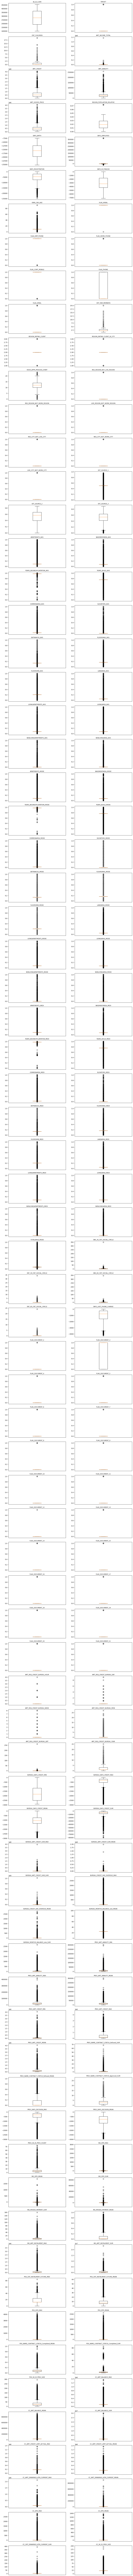

In [20]:
import matplotlib.pyplot as plt
import math

num_cols = app_trainn.select_dtypes(include=['int64', 'float64']).columns.tolist()

plots_per_row = 2
total_plots = len(num_cols)
rows = math.ceil(total_plots / plots_per_row)

plt.figure(figsize=(12, rows * 3))

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, plots_per_row, i)
    plt.boxplot(app_trainn[col].dropna())
    plt.title(col, fontsize=9)
    plt.xticks([])

plt.tight_layout()
plt.show()


OUTLIERS CHECKING BY NUMBERS

In [21]:
# OUTLIERS CHECKING OUR DATASET (NUMERICAL METHOD)

num_cols = app_trainn.select_dtypes(include=['int64', 'float64']).columns.to_list()

for num in num_cols:
    Q1 = app_trainn[num].quantile(0.25)
    Q3 = app_trainn[num].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (app_trainn[num] < lower_bound) | (app_trainn[num] > upper_bound)
    outlier_count = outliers.sum()

    if outlier_count > 0:
        print(f"{num:<40} OUTLIERS = {outlier_count}")


TARGET                                   OUTLIERS = 24825
CNT_CHILDREN                             OUTLIERS = 4272
AMT_INCOME_TOTAL                         OUTLIERS = 14035
AMT_CREDIT                               OUTLIERS = 6562
AMT_ANNUITY                              OUTLIERS = 7504
AMT_GOODS_PRICE                          OUTLIERS = 14728
REGION_POPULATION_RELATIVE               OUTLIERS = 8412
DAYS_EMPLOYED                            OUTLIERS = 72217
DAYS_REGISTRATION                        OUTLIERS = 659
OWN_CAR_AGE                              OUTLIERS = 99562
FLAG_MOBIL                               OUTLIERS = 1
FLAG_EMP_PHONE                           OUTLIERS = 55386
FLAG_WORK_PHONE                          OUTLIERS = 61308
FLAG_CONT_MOBILE                         OUTLIERS = 574
FLAG_EMAIL                               OUTLIERS = 17442
CNT_FAM_MEMBERS                          OUTLIERS = 4007
REGION_RATING_CLIENT                     OUTLIERS = 80527
REGION_RATING_CLIENT_W_CITY

### Data Preprocessing and Outlier Management

This section outlines the final preprocessing steps applied to the master
dataset before model training. The focus is on ensuring data integrity and
handling outliers in a controlled and domain-driven manner.
    
#### 1. Data Integrity and Cleaning Confirmation

Before proceeding to model development, the structural integrity of the
master dataset was verified. Duplicate records were checked to ensure that
each customer (identified by SK_ID_CURR) is represented uniquely.

All missing values have already been handled during preprocessing. Numerical
features were imputed using median values, while categorical features were
converted into numerical representations through encoding. As a result, the
dataset is complete and ready for modeling.

#### 2. Focused Outlier Management Rationale

Outlier handling was performed selectively rather than aggressively. No rows
were removed based on IQR analysis (trimming), as deleting records could lead
to loss of valuable information, especially for defaulter cases in this
imbalanced dataset.

Instead, capping (winsorization) was applied to neutralize the influence of
extreme and unrealistic values while retaining all 307,511 customer records.

##### A. Why Trimming Was Avoided

Removing rows containing outliers was avoided for the following reasons:

- The target variable is highly imbalanced, and trimming may remove rare but
  important defaulter records (TARGET = 1).
- Extreme values often represent genuine high-risk customer behavior in
  credit datasets.
- Preserving all historical credit information improves model robustness and
  real-world applicability.

##### B. Anomalies and Capping Strategy

Capping was applied only to specific financial and demographic features that
could introduce unrealistic influence on the model. Outliers generated due to
statistical imputation (such as building-related features) were ignored, as
they do not represent true behavioral risk.

The following targeted strategies were applied:
- Extreme income values were capped at a high percentile.
- Unusually large values in family-related features were limited to a
  realistic upper bound.
- Known anomalous values in employment history were corrected and explicitly
  flagged.


In [22]:
#Targeted Outlier Capping
# Capping extreme values in CNT_CHILDREN
max_children_limit = 4
app_trainn['CNT_CHILDREN'] = app_trainn['CNT_CHILDREN'].clip(upper=max_children_limit)
print(f"CNT_CHILDREN capped at {max_children_limit}.")

# Capping extreme income values at the 99.5th percentile
income_cap_value = app_trainn['AMT_INCOME_TOTAL'].quantile(0.995)
app_trainn['AMT_INCOME_TOTAL'] = app_trainn['AMT_INCOME_TOTAL'].clip(upper=income_cap_value)
print(f"AMT_INCOME_TOTAL capped at {income_cap_value:.2f}.")

# Handling known anomaly in DAYS_EMPLOYED
app_trainn['DAYS_EMPLOYED_ANOM'] = app_trainn['DAYS_EMPLOYED'] == 365243
app_trainn['DAYS_EMPLOYED'] = app_trainn['DAYS_EMPLOYED'].replace({365243: 0})
print("DAYS_EMPLOYED anomaly cleaned and flagged.")

CNT_CHILDREN capped at 4.
AMT_INCOME_TOTAL capped at 630000.00.
DAYS_EMPLOYED anomaly cleaned and flagged.


### Final Outlier Handling Summary

Outlier treatment was limited to correcting known anomalies and unrealistic
extreme values that could negatively affect model stability. Genuine extreme
values were retained, as they represent real-world customer risk patterns
that are essential for effective loan default prediction.

No records were removed during this process, ensuring full data retention
for subsequent machine learning modeling.


In [23]:
#eda for catergorical using different dataset
app_train.to_csv('app_train_eda.csv', index=False)
app_eda = pd.read_csv("app_train_eda.csv")

### Exploratory Data Analysis – Categorical Features

Categorical feature distributions were analyzed using a separate dataset
containing original (non-encoded) variables. This approach ensures better
interpretability of visualizations. The analysis provides insights into
customer demographics, loan types, and ownership patterns, which are useful
for understanding borrower behavior.


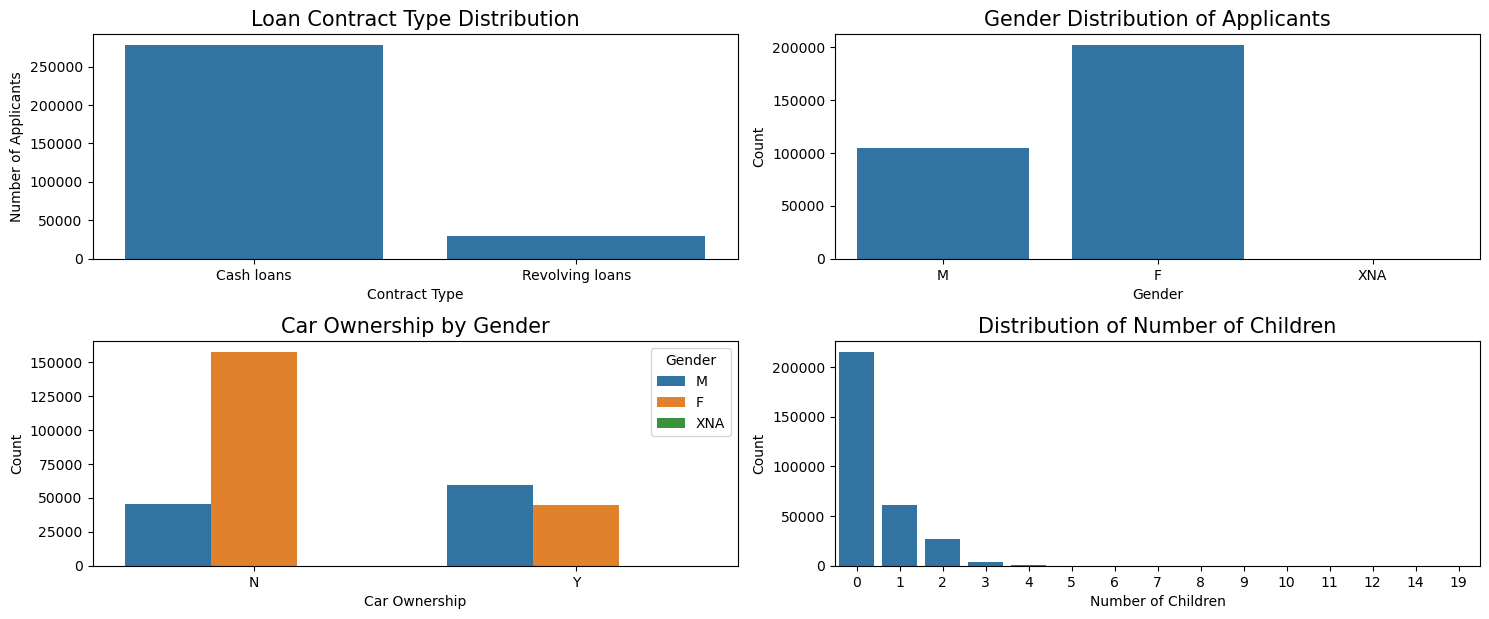

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 12))

plt.subplot(4, 2, 1)
sns.countplot(x="NAME_CONTRACT_TYPE", data=app_eda)
plt.title("Loan Contract Type Distribution", fontsize=15)
plt.xlabel("Contract Type")
plt.ylabel("Number of Applicants")

plt.subplot(4, 2, 2)
sns.countplot(x="CODE_GENDER", data=app_eda)
plt.title("Gender Distribution of Applicants", fontsize=15)
plt.xlabel("Gender")
plt.ylabel("Count")

plt.subplot(4, 2, 3)
sns.countplot(x="FLAG_OWN_CAR", hue="CODE_GENDER", data=app_eda)
plt.title("Car Ownership by Gender", fontsize=15)
plt.xlabel("Car Ownership")
plt.ylabel("Count")
plt.legend(title="Gender")

plt.subplot(4, 2, 4)
sns.countplot(x="CNT_CHILDREN", data=app_eda)
plt.title("Distribution of Number of Children", fontsize=15)
plt.xlabel("Number of Children")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


### Key Categorical Insights

1. Most loan applications belong to cash loans, indicating higher demand
   compared to revolving loans.

2. Female applicants form a larger portion of the customer base, suggesting
   higher participation in loan applications.

3. A significant number of applicants do not own a car, especially among
   female customers.

4. Most applicants have no children or very few dependents, while higher
   counts are extremely rare.


EDA – Numerical Columns (Main Features Only)

In [25]:
pd.set_option('display.max_columns', None)
app_eda.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_MONTHS_BALANCE_size_MEAN,BUREAU_MONTHS_BALANCE_size_SUM,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_SUM,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_SUM,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_SK_ID_PREV_COUNT,INS_DPD_MAX,INS_DPD_MEAN,INS_DPD_SUM,INS_MISSED_PAYMENT_SUM,INS_MISSED_PAYMENT_MEAN,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_SUM,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_DPD_MAX,POS_DPD_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Completed_SUM,POS_SK_ID_PREV_SIZE,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_DPD_MAX,CC_DPD_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_SK_ID_PREV_SIZE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149

The following numerical features were selected for EDA as they have high
impact on credit risk and customer behavior.

1.AMT_CREDIT (Loan Amount):-
The amount that customers have been received.

2.AMT_INCOME_TOTAL (Total Income):-
The annual salaries of customers.

3.AMT_ANNUITY (Loan Annuity Amount):-
EMI of customers.

4.EXT_SOURCE_3 (External Score - High Impact Credit Risk Feature):-
The credit score that bank has been taken from credit bureaus.

5.DAYS_BIRTH:-
It will show the age of customers but in days.

6.BUREAU_DAYS_CREDIT_MEAN:-
It will show your old payment records with old banks.

In [26]:
num_cols = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'EXT_SOURCE_3',
    'DAYS_BIRTH',
    'BUREAU_DAYS_CREDIT_MEAN'
]

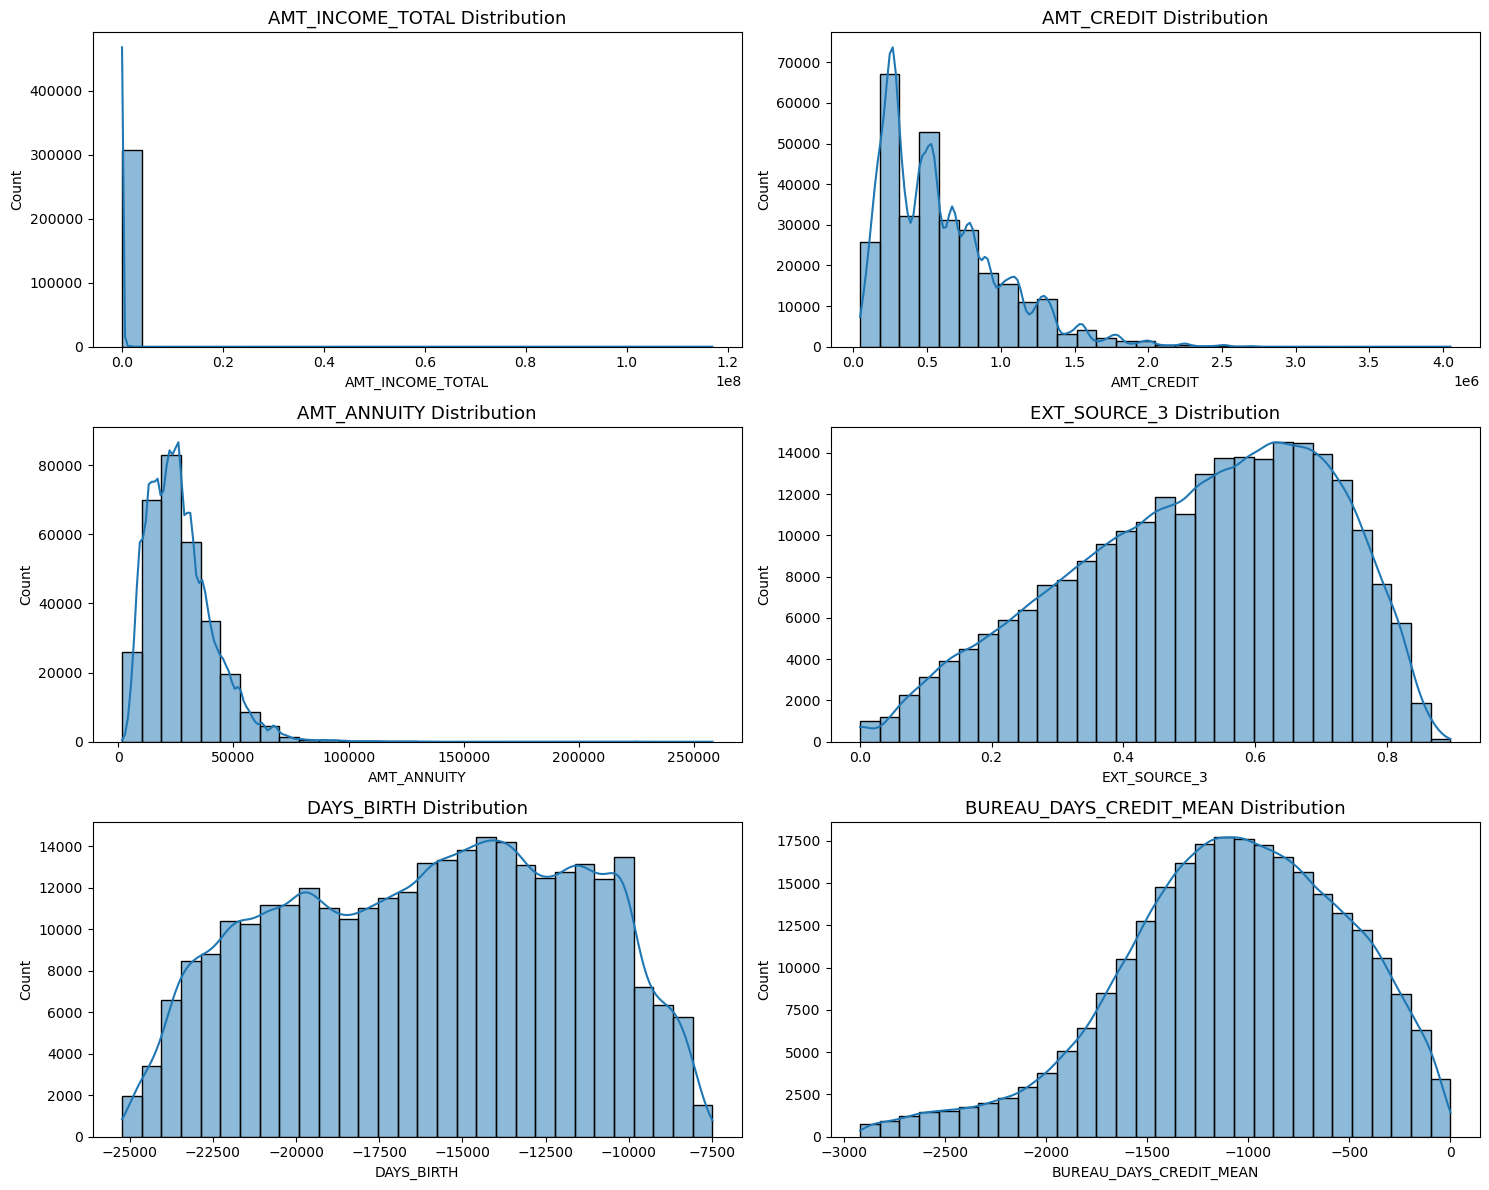

In [27]:
#Distribution Plots (Histogram + KDE)
plt.figure(figsize=(15, 12))

for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(app_eda[col], bins=30, kde=True)
    plt.title(f"{col} Distribution", fontsize=13)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

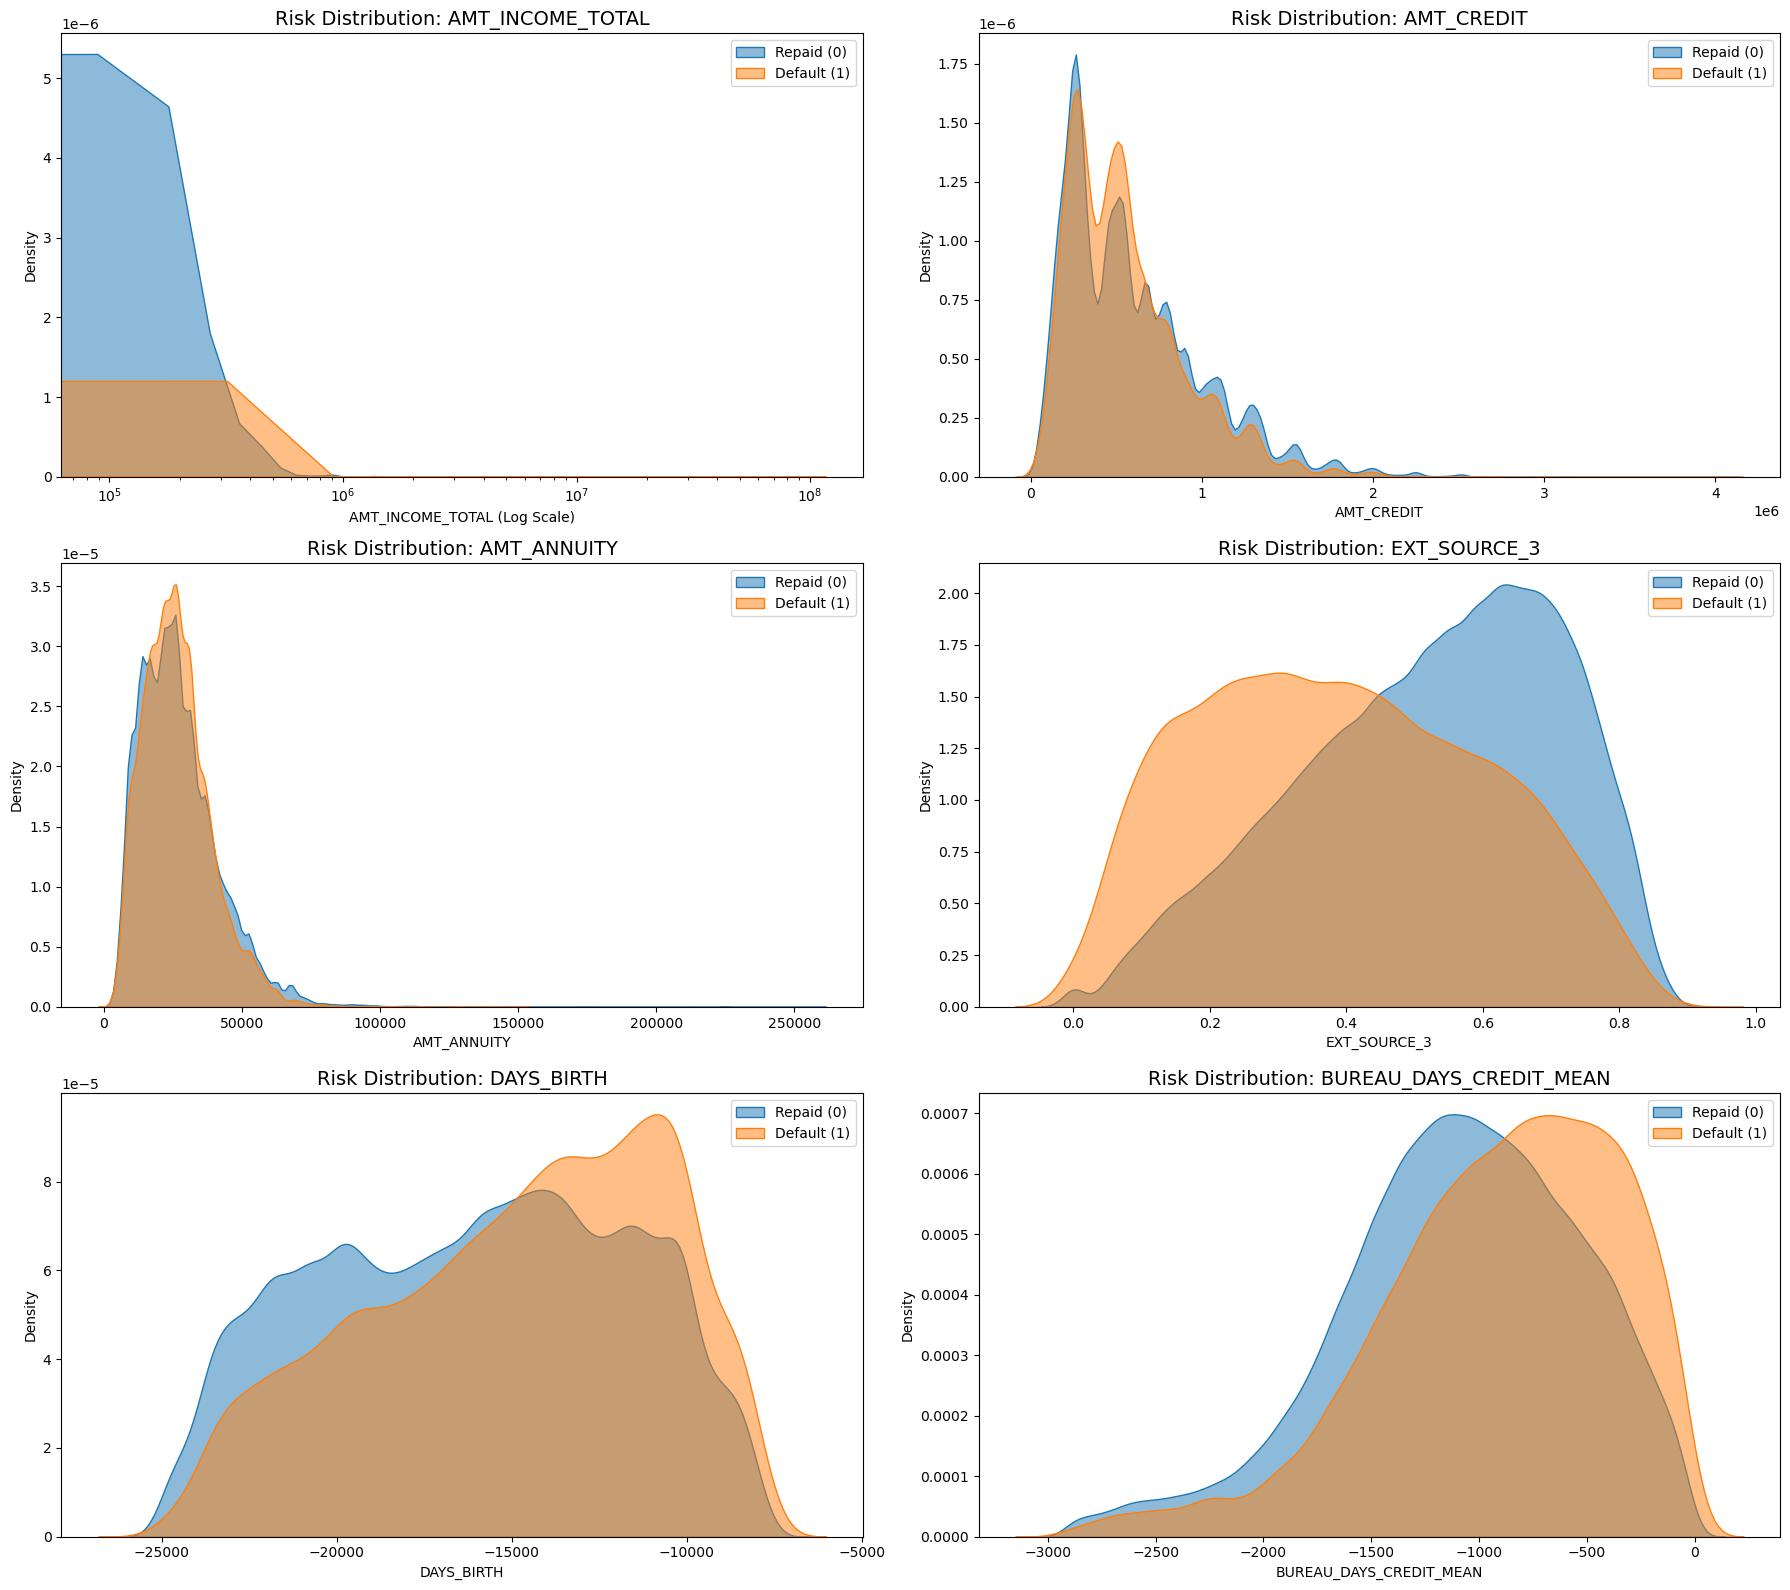

In [28]:
#Risk Distribution (TARGET = 0 vs 1)
plt.figure(figsize=(18, 16))

for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)

    sns.kdeplot(
        app_eda.loc[app_eda['TARGET'] == 0, col],
        label='Repaid (0)', fill=True, alpha=0.5
    )

    sns.kdeplot(
        app_eda.loc[app_eda['TARGET'] == 1, col],
        label='Default (1)', fill=True, alpha=0.5
    )

    if col == 'AMT_INCOME_TOTAL':
        plt.xscale('log')
        plt.xlabel(f'{col} (Log Scale)')

    plt.title(f"Risk Distribution: {col}", fontsize=14)
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()

### Numerical EDA Key Insights

1. EXT_SOURCE_3 is the strongest predictor of default risk, with lower scores
   showing significantly higher default probability.

2. Younger applicants exhibit a slightly higher default risk compared to
   older customers.

3. Customers with very recent credit history tend to show higher risk.

4. Default cases are more concentrated in lower income groups.

5. Loan amount and annuity individually show limited predictive power,
   highlighting the importance of derived ratios such as debt-to-income.


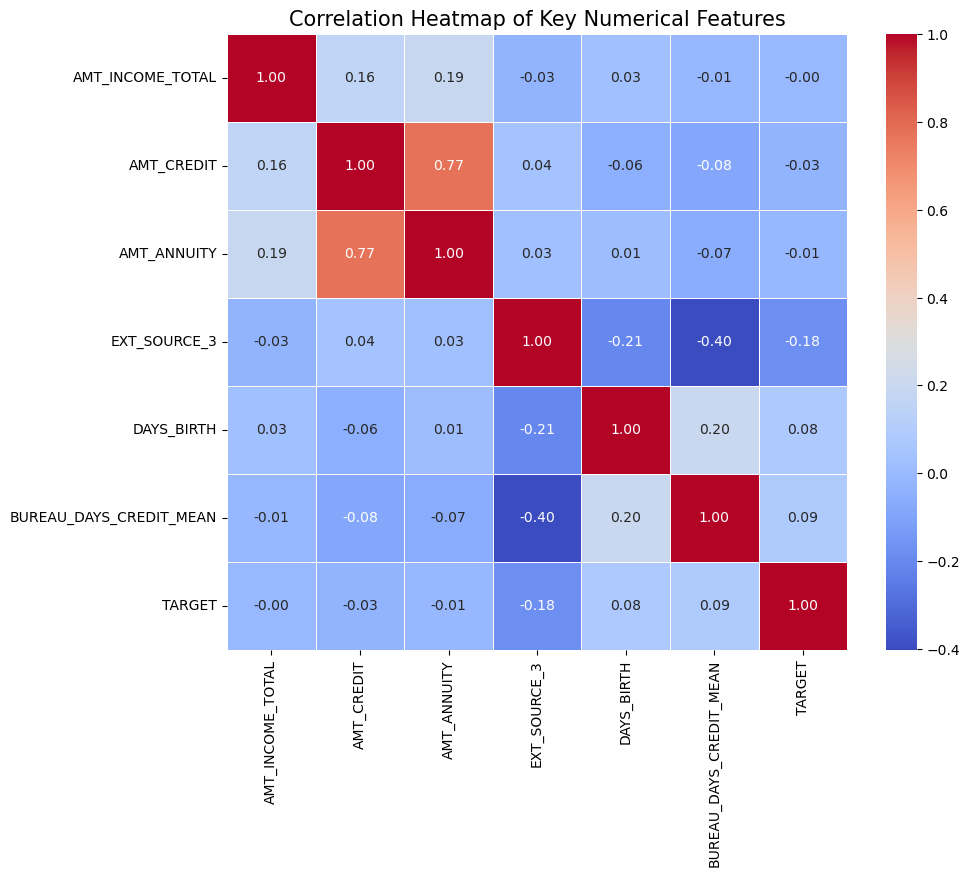

In [29]:
#Correlation Analysis
num_cols_for_corr = num_cols + ['TARGET']
corr_matrix = app_eda[num_cols_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap of Key Numerical Features", fontsize=15)
plt.show()


### Correlation Analysis Insights

External credit score shows the strongest negative correlation with default,
confirming its importance. Credit amount and annuity are strongly correlated,
while income alone shows weak correlation with default risk.


Numerical vs Categorical EDA


Gender vs Income

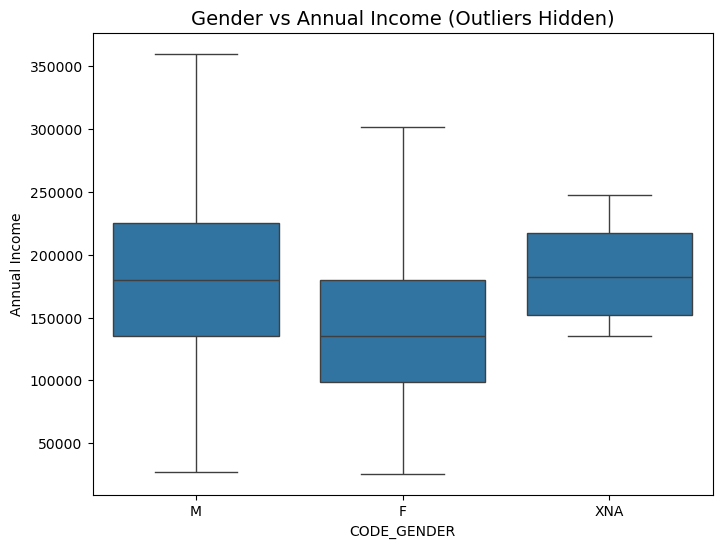

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x='CODE_GENDER',
    y='AMT_INCOME_TOTAL',
    data=app_eda,
    showfliers=False
)
plt.title("Gender vs Annual Income (Outliers Hidden)", fontsize=14)
plt.ylabel("Annual Income")
plt.show()


Loan Type vs Income

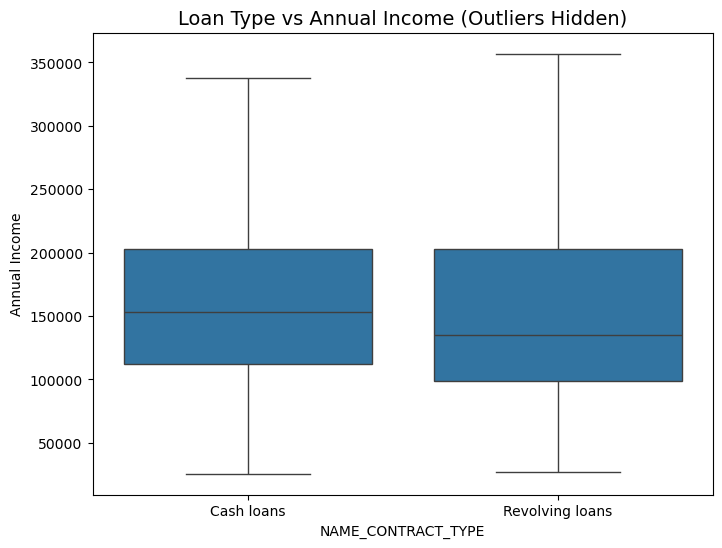

In [31]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x='NAME_CONTRACT_TYPE',
    y='AMT_INCOME_TOTAL',
    data=app_eda,
    showfliers=False
)
plt.title("Loan Type vs Annual Income (Outliers Hidden)", fontsize=14)
plt.ylabel("Annual Income")
plt.show()


### Combined Numerical and Categorical Insights

Income distribution varies across gender and loan types, with cash loan
applicants generally concentrated in lower income brackets. These patterns
support the importance of income-related risk assessment.

Data Preparation for Modeling


In [32]:
#Drop Unnecessary Columns
# Dropping identifier and multicollinear feature
app_trainn = app_trainn.drop(['SK_ID_CURR', 'AMT_ANNUITY'], axis=1)

`SK_ID_CURR` is a unique identifier and does not contribute to prediction.
`AMT_ANNUITY` was removed to reduce multicollinearity since it is highly
correlated with `AMT_CREDIT`.

Feature Scaling

Even though tree models don’t need scaling, Logistic Regression does, and
we want a fair baseline

In [33]:
from sklearn.preprocessing import StandardScaler

X = app_trainn.drop('TARGET', axis=1)
y = app_trainn['TARGET']

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns
)

Feature scaling was applied using StandardScaler to normalize numerical
features with mean 0 and standard deviation 1.

Train–Test Split

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (246008, 288)
Test shape: (61503, 288)


Logistic Regression (Baseline Model)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

lr_baseline = LogisticRegression(
    solver='liblinear',
    random_state=42
)

lr_baseline.fit(X_train, y_train)

y_pred_base = lr_baseline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_base))
print("Classification Report:\n", classification_report(y_test, y_pred_base))

Accuracy: 0.9196136773815912
Confusion Matrix:
 [[56430   108]
 [ 4836   129]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.54      0.03      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.73      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



### Baseline Logistic Regression – Interpretation

The baseline Logistic Regression model achieved high overall accuracy due to
the dominance of non-defaulters in the dataset. However, it failed to
effectively identify defaulters, with extremely low recall for the minority
class.

This highlights a critical limitation of accuracy as an evaluation metric
for imbalanced credit risk datasets.

## Logistic Regression with Class Weighting

In [36]:
lr_weighted = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)

lr_weighted.fit(X_train, y_train)

y_pred_weighted = lr_weighted.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_weighted))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_weighted))
print("Classification Report:\n", classification_report(y_test, y_pred_weighted))

Accuracy: 0.7040794757979285
Confusion Matrix:
 [[39865 16673]
 [ 1527  3438]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.71      0.81     56538
           1       0.17      0.69      0.27      4965

    accuracy                           0.70     61503
   macro avg       0.57      0.70      0.54     61503
weighted avg       0.90      0.70      0.77     61503



### Logistic Regression with Class Weighting – Interpretation

Introducing class weights significantly improved the recall for defaulters,
allowing the model to detect a much larger portion of high-risk customers.
This improvement came at the cost of reduced accuracy and increased false
positives, reflecting a common trade-off in imbalanced classification
problems.

## Probability-Based Evaluation

In [37]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_prob_lr = lr_weighted.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print("PR-AUC:", average_precision_score(y_test, y_prob_lr))

ROC-AUC: 0.7653133432488632
PR-AUC: 0.24750326613149265


### Logistic Regression – Probability-Based Evaluation

ROC-AUC measures the model’s ability to rank defaulters higher than
non-defaulters across all thresholds, while PR-AUC focuses on performance for
the minority class.

These metrics provide a more reliable evaluation for imbalanced datasets
compared to accuracy alone.

## Random Forest Modeling

Random Forest was chosen as the next model because it can capture non-linear
relationships and feature interactions that Logistic Regression cannot.
It also serves as a strong tree-based baseline before moving to boosting
algorithms.

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=50,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_split=50, n_estimators=300, n_jobs=-1,
                       random_state=42)

Random Forest Predictions (Default Threshold)

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_rf = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 0.7822057460611678
Confusion Matrix:
 [[45382 11156]
 [ 2239  2726]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87     56538
           1       0.20      0.55      0.29      4965

    accuracy                           0.78     61503
   macro avg       0.57      0.68      0.58     61503
weighted avg       0.89      0.78      0.82     61503



Probability-Based Evaluation

In [40]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("PR-AUC:", average_precision_score(y_test, y_prob_rf))

ROC-AUC: 0.7506758316742437
PR-AUC: 0.22622941679924613


### Random Forest – Performance Interpretation

Random Forest was evaluated as a non-linear comparison model to assess whether
tree-based learning could improve performance over linear models. However, in
this dataset, Random Forest did not outperform Logistic Regression in terms of
ROC-AUC and PR-AUC.

This outcome suggests that the underlying relationships in the data are largely
linear or monotonic, which Logistic Regression is able to capture effectively.
Additionally, probability estimates from Random Forest were less well
calibrated, leading to weaker precision–recall performance.

As a result, Random Forest was not selected for further optimization, and
boosting-based models were explored to achieve better minority class detection.

## XGBoost Modeling and Optimization

XGBoost was selected as the final modeling approach because it effectively
handles class imbalance, captures non-linear feature interactions, and
provides strong probability ranking performance. These characteristics make
it well-suited for large-scale credit risk prediction problems.

Handle Class Imbalance

In [42]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 3.6 MB/s eta 0:00:20
   - -------------------------------------- 2.6/72.0 MB 7.1 MB/s eta 0:00:10
   --- ------------------------------------ 5.5/72.0 MB 9.5 MB/s eta 0:00:08
   ---- ----------------------------------- 7.9/72.0 MB 10.1 MB/s eta 0:00:07
   ----- ---------------------------------- 10.7/72.0 MB 10.7 MB/s eta 0:00:06
   ------- -------------------------------- 13.6/72.0 MB 11.4 MB/s eta 0:00:06
   --------- ------------------------------ 16.5/72.0 MB 11.6 MB/s eta 0:00:05
   ---------- ----------------------------- 19.4/72.0 MB 12.0 MB/s eta 0:00:05
   ------------ --------------------------- 22.3/72.0 MB 12.1 MB/s eta 0:00:05
   ------------- -------------------------- 25.2/72.0 MB 12.4 MB/s eta 0:00:04
   --------------- ------------------------ 28.6/72.0 MB 12.7 MB/s eta 0:00:0

In [43]:
from xgboost import XGBClassifier

# Calculate imbalance ratio
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
pos_weight

np.float64(11.38710976837865)

The `scale_pos_weight` parameter was used to compensate for class imbalance by
assigning higher importance to the minority (default) class during training.

In [44]:
xgb_model = XGBClassifier(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    eval_metric='aucpr',
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=600,
              n_jobs=None, num_parallel_tree=None, ...)

Probability-Based Evaluation

In [45]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print("PR-AUC:", average_precision_score(y_test, y_prob_xgb))

ROC-AUC: 0.7789789394558115
PR-AUC: 0.276167111253133


XGBoost achieved the highest ROC-AUC and PR-AUC scores among all evaluated
models. This indicates superior ranking ability and improved detection of
high-risk customers compared to Logistic Regression and Random Forest.

Threshold Optimization (F1-Based Baseline)

In [46]:
from sklearn.metrics import precision_recall_curve
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)

f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)

best_threshold_f1 = thresholds[best_idx]

print("Best Threshold (F1):", best_threshold_f1)
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])
print("F1:", f1_scores[best_idx])

Best Threshold (F1): 0.6668062
Precision: 0.2772084576469062
Recall: 0.4304128902316213
F1: 0.3372258118668507


In [47]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_f1 = (y_prob_xgb >= best_threshold_f1).astype(int)

print(confusion_matrix(y_test, y_pred_f1))
print(classification_report(y_test, y_pred_f1))


[[50966  5572]
 [ 2828  2137]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     56538
           1       0.28      0.43      0.34      4965

    accuracy                           0.86     61503
   macro avg       0.61      0.67      0.63     61503
weighted avg       0.89      0.86      0.88     61503



By optimizing the decision threshold using the F1-score, the model achieved a
balanced trade-off between Precision and Recall for defaulters. This approach
significantly improved default detection compared to fixed-threshold models.

Business-Driven Threshold Optimization

Business Rule:

Catch at least 60% of defaulters, while maximizing precision.

In [48]:
# Business-driven threshold selection
recall_target = 0.60

valid_idx = np.where(recall >= recall_target)[0]
best_business_idx = valid_idx[np.argmax(precision[valid_idx])]

business_threshold = thresholds[best_business_idx]

print("Business Threshold:", business_threshold)
print("Precision:", precision[best_business_idx])
print("Recall:", recall[best_business_idx])


Business Threshold: 0.5590113
Precision: 0.21252764500249696
Recall: 0.6


In [49]:
y_pred_business = (y_prob_xgb >= business_threshold).astype(int)

print(confusion_matrix(y_test, y_pred_business))
print(classification_report(y_test, y_pred_business))


[[45500 11038]
 [ 1986  2979]]
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     56538
           1       0.21      0.60      0.31      4965

    accuracy                           0.79     61503
   macro avg       0.59      0.70      0.59     61503
weighted avg       0.90      0.79      0.83     61503



Instead of optimizing purely for mathematical balance, a business-driven
threshold was selected to ensure a minimum recall of defaulters. This aligns
the model with real-world banking objectives, where missing defaulters is
significantly more costly than rejecting safe customers.

## XGBoost Modeling and Optimization

XGBoost was selected as the final model for this project due to its strong ability to handle imbalanced datasets, learn non-linear relationships, and capture complex interactions between features. These properties make XGBoost particularly suitable for credit risk prediction, where default behavior is influenced by multiple interacting financial and behavioral factors.

To address class imbalance, the scale_pos_weight parameter was used, ensuring that default cases received higher importance during model training.

## Model Training and Evaluation

The XGBoost classifier was trained using engineered and scaled features. Model performance was evaluated using probability-based metrics that are more reliable for imbalanced classification problems.

Performance Metrics:

ROC-AUC: 0.78

PR-AUC: 0.27

These results indicate that XGBoost has strong ranking capability and provides better separation between defaulters and non-defaulters compared to previously evaluated models.

ROC-AUC reflects the model’s ability to rank risky customers higher than safe ones, while PR-AUC highlights improved performance on the minority class, which is critical in loan default prediction.

## Threshold Optimization Using F1-Score

Instead of using the default probability threshold of 0.5, threshold tuning was applied to improve detection of defaulters. The optimal threshold was selected by maximizing the F1-score, which balances Precision and Recall for the default class.

Optimal Threshold: 0.656

At this threshold:

Precision (Defaulters): 0.26

Recall (Defaulters): 0.44

F1-Score: 0.33

This adjustment significantly improved the model’s ability to identify high-risk customers while maintaining reasonable precision.

## Confusion Matrix Analysis

At the optimized threshold, the model:

Correctly identified 50,439 non-defaulters

Correctly identified 2,161 defaulters

Missed 2,788 defaulters

Incorrectly flagged 6,115 safe customers

Although overall accuracy decreased slightly compared to default-threshold models, the improvement in defaulter detection represents a more practical outcome for financial institutions.